In [44]:
import wave
import glob
import random

# for data, model, training
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy import signal

# for visuals and statistics
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seed value for experiment reproducibility.
seed = 42
random.seed(42)
tf.random.set_seed(seed)
np.random.seed(seed)

In [45]:
def get_and_shuffle_filenames(dir_name):
    filenames = glob.glob(str(data_dir) + "/*")
    random.shuffle(filenames)
    return filenames

data_dir = "recordings"
filenames = get_and_shuffle_filenames(data_dir)

print(filenames[:5])

['recordings/2_jackson_13.wav', 'recordings/6_george_34.wav', 'recordings/7_george_5.wav', 'recordings/1_yweweler_21.wav', 'recordings/2_george_42.wav']


In [46]:
# https://www.tensorflow.org/tutorials/audio/simple_audio

def decode_audio(file_path):
    # read file to get buffer                                                                                               
    ifile = wave.open(file_path)
    samples = ifile.getnframes()
    audio = ifile.readframes(samples)

    # convert buffer to float32 using NumPy                                                                                 
    audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
    audio_as_np_float32 = audio_as_np_int16.astype(np.float32)
    
    # get largest absolute value
    max_val = np.max(
        np.absolute(
            [np.max(audio_as_np_float32), np.min(audio_as_np_float32)]))
    audio_normalized = audio_as_np_float32 / max_val

    return audio_normalized

def get_label(file_path):
    # label is in the filename
    parts = file_path.split("/")
    label = int(parts[1].split("_")[0])

    return label


In [47]:
# to remove outliers 
X_unfiltered = [(file_path, decode_audio(file_path)) for file_path in filenames]
X_lengths = [audio.shape[0] for _, audio in X_unfiltered]

max_length = int(np.mean(X_lengths) + 2 * np.std(X_lengths))
print(np.mean(X_lengths))
print(np.std(X_lengths))
print(max_length)

3499.4746666666665
1180.9471707171701
5861


In [48]:
# padding function from
# https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

X_full = [] # padded X values
y_full = []

numbers = [0] * 10

for file_path, audio in X_unfiltered:
    x_val = audio
    y_val = get_label(file_path)
    
    signal_length = audio.shape[0]
    if signal_length > max_length:
        numbers[y_val] += 1
    else:
        pad_len = max_length - signal_length
        
        x_val = np.pad(
            x_val, (0, pad_len), 
            'constant', constant_values=(0, 0))
        
        X_full.append(x_val)
        y_full.append(y_val)

X_full = np.array(X_full)
y_full = np.array(y_full)

num_samples, sample_length = X_full.shape
print(num_samples)
print(sample_length)

2911
5861


In [49]:
# quantities = {"y": list(range(10)), "quantities": numbers}
df = pd.DataFrame.from_dict({"quantities": numbers})
print(df)
print(sum(numbers))

   quantities
0          11
1           8
2           6
3           5
4           3
5           6
6          23
7          11
8           6
9          10
89


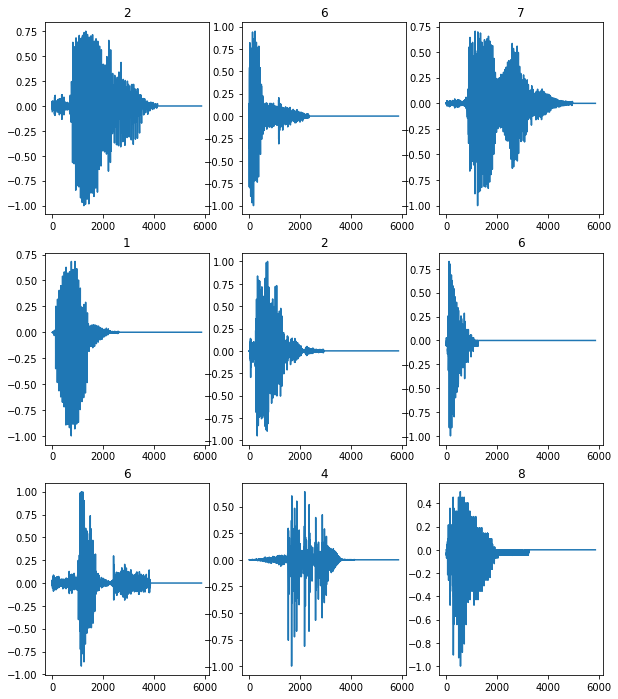

In [50]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(list(zip(X_full, y_full))[:n]):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio)
#     ax.set_yticks(np.arange(-1,1.5,0.5))
    ax.set_title(label)

plt.show()

In [51]:
tenth = int(num_samples * 0.1)
eightyth = tenth * 8

X_train = X_full[:eightyth]
y_train = y_full[:eightyth]

X_val = X_full[eightyth: eightyth + tenth]
y_val = y_full[eightyth: eightyth + tenth]

X_test = X_full[eightyth + tenth:]
y_test = y_full[eightyth + tenth:]

print('Training set size', len(X_train))
print('Validation set size', len(X_val))
print('Test set size', len(X_test))

Training set size 2328
Validation set size 291
Test set size 292


In [52]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1000, activation="softmax", input_shape=(sample_length,)))
# model.add(tf.keras.layers.Dense(100, activation="softmax"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.build()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1000)              5862000   
                                                                 
 dense_12 (Dense)            (None, 10)                10010     
                                                                 
Total params: 5,872,010
Trainable params: 5,872,010
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [54]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_val, y_val))

Epoch 1/30
73/73 [==============================] - 1s 16ms/step - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3041 - val_accuracy: 0.0893
Epoch 2/30
73/73 [==============================] - 1s 13ms/step - loss: 2.2975 - accuracy: 0.1847 - val_loss: 2.3033 - val_accuracy: 0.1134
Epoch 3/30
73/73 [==============================] - 1s 13ms/step - loss: 2.2789 - accuracy: 0.3153 - val_loss: 2.2947 - val_accuracy: 0.1340
Epoch 4/30
73/73 [==============================] - 1s 14ms/step - loss: 2.2334 - accuracy: 0.4403 - val_loss: 2.2783 - val_accuracy: 0.1512
Epoch 5/30
73/73 [==============================] - 1s 14ms/step - loss: 2.1679 - accuracy: 0.5275 - val_loss: 2.2624 - val_accuracy: 0.1546
Epoch 6/30
73/73 [==============================] - 1s 18ms/step - loss: 2.0908 - accuracy: 0.6379 - val_loss: 2.2472 - val_accuracy: 0.1718
Epoch 7/30
73/73 [==============================] - 1s 14ms/step - loss: 2.0116 - accuracy: 0.7023 - val_loss: 2.2339 - val_accuracy: 0.1924
Epoch 8/30
73

In [55]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 2.1770 - accuracy: 0.2329


[2.1769654750823975, 0.232876718044281]

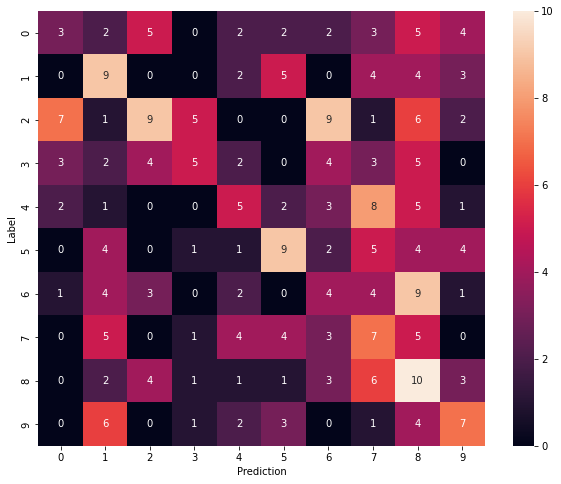

In [56]:
y_pred = np.argmax(model.predict(X_test), axis=1)

all_labels = list(range(10))

confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=all_labels,
            yticklabels=all_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [57]:
model.save("model_v1.h5")